# Übung 1, Aufgabe 2 (Zielkonflikte)

**Einordnung in Übung 1:**

- Aufgabe 1: Basismodell der Produktionsprogrammplanung (PPP)
- **Aufgabe 2: Basismodell mit Zielkonflikt**
- Aufgabe 3: Erweiterung um mehrere Perioden und Lagerbestände

## Aufgabenstellung

- Hersteller Möbel AG (Produkte: Schlaf- und Wohnzimmer)
- Fixe Kosten im Planungszeitraum in Höhe von 30.000 GE
- Kapazitäten der Abteilungen I, II und III: 160, 180 und 150 ZE

<img width='700px' align='left' src='https://raw.githubusercontent.com/tzimmer4/PuL/master/Images/A2_data1.JPG'>


- Problem: Zielkonflikt zwischen Maximierung DB und Umsatz
- Lösung über Maximierung des minimalen Zielerreichungsgrades

## Vorbereitung

### Python-Module

In [1]:
import numpy as np
import pandas as pd
from pulp import *
import qgrid
import ipywidgets as widgets
gropt = {'minVisibleRows': 2}

### Daten aus Aufgabenstellung

Produktionskoeffizienten (Kapazitätsinanspruchnahme) der zwei Produkte in den drei Abteilungen:

In [2]:
# Produktionskoeffizienten
a = pd.DataFrame()
a.loc['Schlafzimmer','Abteilung_I'] = 2
a.loc['Schlafzimmer','Abteilung_II'] = 2
a.loc['Schlafzimmer','Abteilung_III'] = 0
a.loc['Wohnzimmer','Abteilung_I'] = 4
a.loc['Wohnzimmer','Abteilung_II'] = 2
a.loc['Wohnzimmer','Abteilung_III'] = 3

qgrid_widget_a = qgrid.show_grid(a, grid_options = gropt)
qgrid_widget_a

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Maximale Kapazitäten der drei Abteilungen:

In [3]:
# Kapazitaeten
r = pd.DataFrame()
r.loc['Abteilung_I','r'] = 160
r.loc['Abteilung_II','r'] = 180
r.loc['Abteilung_III','r'] = 150

qgrid_widget_r = qgrid.show_grid(r, grid_options = gropt)
qgrid_widget_r

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Preise, Stückkosten und Absatzhöchstmengen der beiden Produkte:

In [4]:
# Weitere Inputdaten
data = pd.DataFrame()
data.loc['Schlafzimmer','Preis'] = 9000
data.loc['Schlafzimmer','Absatzhoechstmenge'] = 85
data.loc['Schlafzimmer','VariableStueckkosten'] = 7000
data.loc['Wohnzimmer','Preis'] = 19500
data.loc['Wohnzimmer','Absatzhoechstmenge'] = 50
data.loc['Wohnzimmer','VariableStueckkosten'] = 16000

qgrid_widget_data = qgrid.show_grid(data, grid_options = gropt)
qgrid_widget_data

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

**Inputdaten für das Optimierungsproblem:**

In [5]:
# Dataframes aktualisieren
a = qgrid_widget_a.get_changed_df()
r = qgrid_widget_r.get_changed_df()
data = qgrid_widget_data.get_changed_df()

# Deckungsbeitrag
for x in data.index.tolist():
    data.loc[x,'DB'] = data.loc[x,'Preis'] - data.loc[x,'VariableStueckkosten']

Produkte = a.index.tolist()
Abteilungen = a.columns.tolist()

print('Produktionskoeffizienten:')
print(a)
print()
print('Maximale Kapazitäten:')
print(r)
print()
print('Weitere Inputdaten:')
print(data)

Produktionskoeffizienten:
              Abteilung_I  Abteilung_II  Abteilung_III
Schlafzimmer          2.0           2.0            0.0
Wohnzimmer            4.0           2.0            3.0

Maximale Kapazitäten:
                   r
Abteilung_I    160.0
Abteilung_II   180.0
Abteilung_III  150.0

Weitere Inputdaten:
                Preis  Absatzhoechstmenge  VariableStueckkosten      DB
Schlafzimmer   9000.0                85.0                7000.0  2000.0
Wohnzimmer    19500.0                50.0               16000.0  3500.0


## Optimierungsprobleme

### a) Maximierung Deckungsbeitrag

#### Problemformulierung


$$\max \sum_{i}x_i \cdot DB_i$$

$$ Restriktionen: $$

$$ \sum_{i}a_{ij} \cdot x_i \leq r_{j} \quad \forall j \in J $$

$$ x_i \leq A_{i} \quad \forall i \in I $$

$$ x_i \geq 0 \quad \forall i \in I $$

$$ \textrm{mit Produkten $I$ und Abteilungen $J$} $$.


**Formulierung in PuLP:**

In [6]:
probDB = LpProblem('Problem_MoebelAG_MaxDB', LpMaximize)

xDB = LpVariable.dicts('Anzahl', Produkte, lowBound=0)

probDB += lpSum([xDB[i]*data.loc[i,'DB'] for i in Produkte]), "Zielfunktion"

for j in Abteilungen:
    probDB += lpSum([xDB[i]* a.loc[i,j] for i in Produkte]) <= r.loc[j,'r'], "Kapazitaetsrestriktion_%s"%j
    
for i in Produkte:
    probDB += xDB[i] <= data.loc[i,'Absatzhoechstmenge'], "Absatzrestriktion_%s"%i
    
print(probDB)

Problem_MoebelAG_MaxDB:
MAXIMIZE
2000.0*Anzahl_Schlafzimmer + 3500.0*Anzahl_Wohnzimmer + 0.0
SUBJECT TO
Kapazitaetsrestriktion_Abteilung_I: 2 Anzahl_Schlafzimmer
 + 4 Anzahl_Wohnzimmer <= 160

Kapazitaetsrestriktion_Abteilung_II: 2 Anzahl_Schlafzimmer
 + 2 Anzahl_Wohnzimmer <= 180

Kapazitaetsrestriktion_Abteilung_III: 3 Anzahl_Wohnzimmer <= 150

Absatzrestriktion_Schlafzimmer: Anzahl_Schlafzimmer <= 85

Absatzrestriktion_Wohnzimmer: Anzahl_Wohnzimmer <= 50

VARIABLES
Anzahl_Schlafzimmer Continuous
Anzahl_Wohnzimmer Continuous



#### Ergebnis

In [7]:
probDB.writeLP("MoebelAG_MaxDB.lp")
probDB.solve()

print("Status:", LpStatus[probDB.status])
print("Erzielter Deckungsbeitrag = {:,.0f} GE".format(value(probDB.objective)))
print()

for i in Produkte:
    print('Optimale Produktionsmenge {}: {:,.2f} ME'.format(i, xDB[i].varValue))

Status: Optimal
Erzielter Deckungsbeitrag = 160,000 GE

Optimale Produktionsmenge Schlafzimmer: 80.00 ME
Optimale Produktionsmenge Wohnzimmer: 0.00 ME


**Plotten des Problems und der optimalen Produktionsprogramms:**

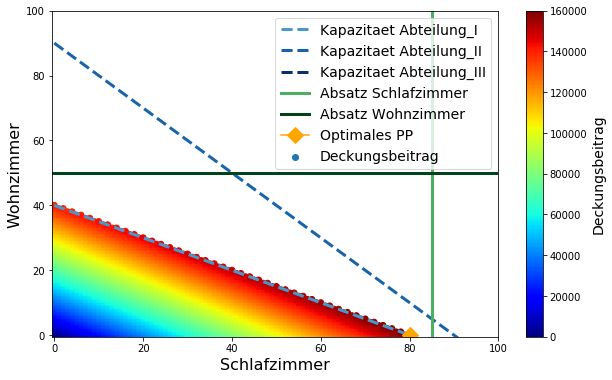

In [8]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
s = np.linspace(0, 100)

# Kapazitätsrestriktionen
colors1 = plt.cm.Blues(np.linspace(0.6,1.0,3))
n = 0
for j in Abteilungen:    
    plt.plot(s,(r.loc[j,'r']-s*a.loc['Schlafzimmer',j])/a.loc['Wohnzimmer',j], lw=3,
             c=colors1[n], linestyle='dashed', label='Kapazitaet '+j)
    n += 1
    
# Absatzrestriktionen
colors2 = plt.cm.Greens(np.linspace(0.6,1.0,2))
plt.axvline(x=data.loc['Schlafzimmer','Absatzhoechstmenge'], lw=3,
            c=colors2[0],linestyle='solid', label='Absatz Schlafzimmer')
plt.axhline(y=data.loc['Wohnzimmer','Absatzhoechstmenge'], lw=3,
            c=colors2[1], linestyle='solid', label='Absatz Wohnzimmer')

# Zielfunktion plotten
pairs = [(x, y) for x in np.arange(101)
                for y in np.arange(101)
                if (x * a.loc['Schlafzimmer','Abteilung_I'] + y * a.loc['Wohnzimmer','Abteilung_I']) <= r.loc['Abteilung_I','r']
                and (x * a.loc['Schlafzimmer','Abteilung_II'] + y * a.loc['Wohnzimmer','Abteilung_II']) <= r.loc['Abteilung_II','r']
                and (x * a.loc['Schlafzimmer','Abteilung_III'] + y * a.loc['Wohnzimmer','Abteilung_III']) <= r.loc['Abteilung_III','r']         
                and x <= data.loc['Schlafzimmer','Absatzhoechstmenge']
                and y <= data.loc['Wohnzimmer','Absatzhoechstmenge']]

xx, xy = np.hsplit(np.array(pairs), 2)
z = xx * data.loc['Schlafzimmer','DB']  + xy * data.loc['Wohnzimmer','DB']  # the objective function
plt.scatter(xx, xy, c=z, cmap='jet', label='Deckungsbeitrag', zorder=2)

# Optimales Produktionsprogramm
plt.plot([xDB['Schlafzimmer'].varValue], [xDB['Wohnzimmer'].varValue], marker='D', markersize=12,
         label='Optimales PP', color="orange")


# Diagramm erstellen
cb = plt.colorbar()
cb.set_label('Deckungsbeitrag', fontsize=14)
plt.xlabel('Schlafzimmer', fontsize=16)
plt.ylabel('Wohnzimmer', fontsize=16)
plt.xlim(-0.5, 100)
plt.ylim(-0.5, 100)
plt.legend(fontsize=14)
plt.show()

### b) Maximierung Umsatz

#### Problemformulierung


$$\max \sum_{i}x_i \cdot P_i$$

$$ Restriktionen: $$

$$ \sum_{i} a_{ij} \cdot x_i \leq r_{j} \quad \forall j \in J $$

$$ x_i \leq A_{i} \quad \forall i \in I $$

$$ x_i \geq 0 \quad \forall i \in I $$

$$ \textrm{mit Produkten $I$ und Abteilungen $J$} $$.

**Formulierung in PuLP:**

In [9]:
probU = LpProblem('Problem_MoebelAG_MaxUmsatz', LpMaximize)

xU = LpVariable.dicts('Anzahl', Produkte, lowBound=0)

probU += lpSum([xU[i]*data.loc[i,'Preis'] for i in Produkte]), "Zielfunktion"

for j in Abteilungen:
    probU += lpSum([xU[i]* a.loc[i,j] for i in Produkte]) <= r.loc[j,'r'], "Kapazitaetsrestriktion_%s"%j
    
for i in Produkte:
    probU += xU[i] <= data.loc[i,'Absatzhoechstmenge'], "Absatzrestriktion_%s"%i
    
print(probU)

Problem_MoebelAG_MaxUmsatz:
MAXIMIZE
9000.0*Anzahl_Schlafzimmer + 19500.0*Anzahl_Wohnzimmer + 0.0
SUBJECT TO
Kapazitaetsrestriktion_Abteilung_I: 2 Anzahl_Schlafzimmer
 + 4 Anzahl_Wohnzimmer <= 160

Kapazitaetsrestriktion_Abteilung_II: 2 Anzahl_Schlafzimmer
 + 2 Anzahl_Wohnzimmer <= 180

Kapazitaetsrestriktion_Abteilung_III: 3 Anzahl_Wohnzimmer <= 150

Absatzrestriktion_Schlafzimmer: Anzahl_Schlafzimmer <= 85

Absatzrestriktion_Wohnzimmer: Anzahl_Wohnzimmer <= 50

VARIABLES
Anzahl_Schlafzimmer Continuous
Anzahl_Wohnzimmer Continuous



#### Ergebnis

In [10]:
probU.writeLP("MoebelAG_MaxUmsatz.lp")
probU.solve()

print("Status:", LpStatus[probU.status])
print("Erzielter Umsatz = {:,.0f} GE".format(value(probU.objective)))
print()

for i in Produkte:
    print('Optimale Produktionsmenge {}: {:,.2f} ME'.format(i, xU[i].varValue))


Status: Optimal
Erzielter Umsatz = 780,000 GE

Optimale Produktionsmenge Schlafzimmer: 0.00 ME
Optimale Produktionsmenge Wohnzimmer: 40.00 ME


**Plotten des Problems und der optimalen Produktionsprogramms:**

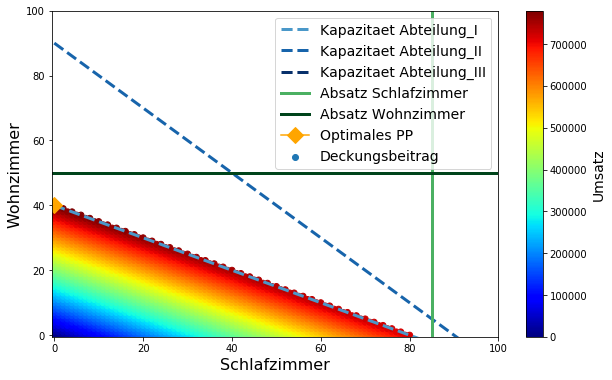

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
s = np.linspace(0, 100)

# Kapazitätsrestriktionen
colors1 = plt.cm.Blues(np.linspace(0.6,1.0,3))
n = 0
for j in Abteilungen:    
    plt.plot(s,(r.loc[j,'r']-s*a.loc['Schlafzimmer',j])/a.loc['Wohnzimmer',j], lw=3,
             c=colors1[n], linestyle='dashed', label='Kapazitaet '+j)
    n += 1
    
# Absatzrestriktionen
colors2 = plt.cm.Greens(np.linspace(0.6,1.0,2))
plt.axvline(x=data.loc['Schlafzimmer','Absatzhoechstmenge'], lw=3,
            c=colors2[0],linestyle='solid', label='Absatz Schlafzimmer')
plt.axhline(y=data.loc['Wohnzimmer','Absatzhoechstmenge'], lw=3,
            c=colors2[1], linestyle='solid', label='Absatz Wohnzimmer')

# Zielfunktion plotten
pairs = [(x, y) for x in np.arange(101)
                for y in np.arange(101)
                if (x * a.loc['Schlafzimmer','Abteilung_I'] + y * a.loc['Wohnzimmer','Abteilung_I']) <= r.loc['Abteilung_I','r']
                and (x * a.loc['Schlafzimmer','Abteilung_II'] + y * a.loc['Wohnzimmer','Abteilung_II']) <= r.loc['Abteilung_II','r']
                and (x * a.loc['Schlafzimmer','Abteilung_III'] + y * a.loc['Wohnzimmer','Abteilung_III']) <= r.loc['Abteilung_III','r']         
                and x <= data.loc['Schlafzimmer','Absatzhoechstmenge']
                and y <= data.loc['Wohnzimmer','Absatzhoechstmenge']]

xx, xy = np.hsplit(np.array(pairs), 2)
z = xx * data.loc['Schlafzimmer','Preis']  + xy * data.loc['Wohnzimmer','Preis']  # the objective function
plt.scatter(xx, xy, c=z, cmap='jet', label='Deckungsbeitrag', zorder=2)

# Optimales Produktionsprogramm
plt.plot([xU['Schlafzimmer'].varValue], [xU['Wohnzimmer'].varValue], marker='D', markersize=12,
         label='Optimales PP', color="orange")


# Diagramm erstellen
cb = plt.colorbar()
cb.set_label('Umsatz', fontsize=14)
plt.xlabel('Schlafzimmer', fontsize=16)
plt.ylabel('Wohnzimmer', fontsize=16)
plt.xlim(-0.5, 100)
plt.ylim(-0.5, 100)
plt.legend(fontsize=14)
plt.show()

### c) Maximierung des minimalen Zielerreichungsgrads

**Ergebnisse der Optimierung mit einem Ziel:**

In [12]:
print("Deckungsbeitrag: Maximum DB* = {:,.0f} GE mit PP ({:.0f}|{:.0f})".format(
    value(probDB.objective), xDB['Wohnzimmer'].varValue, xDB['Schlafzimmer'].varValue))
print("Umsatz: Maximum U* = {:,.0f} GE mit PP ({:.0f}|{:.0f})".format(
    value(probU.objective), xU['Wohnzimmer'].varValue, xU['Schlafzimmer'].varValue))
print()

Deckungsbeitrag: Maximum DB* = 160,000 GE mit PP (0|80)
Umsatz: Maximum U* = 780,000 GE mit PP (40|0)



#### Problemformulierung

$$\max Z$$

$$ Restriktionen: $$

$$ \sum_{i}a_{ij} \leq r_{j} \quad \forall j \in J $$

$$ x_i \leq A_{i} \quad \forall i \in I $$

$$ \sum_{i}x_i \cdot DB_i \geq Z \cdot DB^{*} $$

$$ \sum_{i}x_i \cdot P_i \geq Z \cdot U^{*} $$

$$ x_i \geq 0 \quad \forall i \in I $$

$$ \textrm{mit Produkten $I$ und Abteilungen $J$} $$.

**Problemformulierung in PuLP:**

In [13]:
prob = LpProblem('Problem_MoebelAG_MaxZ', LpMaximize)

xZ = LpVariable.dicts('Anzahl', Produkte, lowBound=0)
Z = LpVariable('Zielerreichungsgrad', lowBound=0)

prob += Z, "Zielfunktion"

for j in Abteilungen:
    prob += lpSum([xZ[i]* a.loc[i,j] for i in Produkte]) <= r.loc[j,'r'], "Kapazitaetsrestriktion_%s"%j
    
for i in Produkte:
    prob += xZ[i] <= data.loc[i,'Absatzhoechstmenge'], "Absatzrestriktion_%s"%i
        
prob += lpSum([xZ[i]*data.loc[i,'DB'] for i in Produkte]) >= Z * value(probDB.objective), "Zielerreichung_DB"
prob += lpSum([xZ[i]*data.loc[i,'Preis'] for i in Produkte]) >= Z * value(probU.objective), "Zielerreichung_Umsatz"
    
print(prob)

Problem_MoebelAG_MaxZ:
MAXIMIZE
1*Zielerreichungsgrad + 0
SUBJECT TO
Kapazitaetsrestriktion_Abteilung_I: 2 Anzahl_Schlafzimmer
 + 4 Anzahl_Wohnzimmer <= 160

Kapazitaetsrestriktion_Abteilung_II: 2 Anzahl_Schlafzimmer
 + 2 Anzahl_Wohnzimmer <= 180

Kapazitaetsrestriktion_Abteilung_III: 3 Anzahl_Wohnzimmer <= 150

Absatzrestriktion_Schlafzimmer: Anzahl_Schlafzimmer <= 85

Absatzrestriktion_Wohnzimmer: Anzahl_Wohnzimmer <= 50

Zielerreichung_DB: 2000 Anzahl_Schlafzimmer + 3500 Anzahl_Wohnzimmer
 - 160000 Zielerreichungsgrad >= 0

Zielerreichung_Umsatz: 9000 Anzahl_Schlafzimmer + 19500 Anzahl_Wohnzimmer
 - 780000 Zielerreichungsgrad >= 0

VARIABLES
Anzahl_Schlafzimmer Continuous
Anzahl_Wohnzimmer Continuous
Zielerreichungsgrad Continuous



#### Ergebnis

In [14]:
prob.writeLP("MoebelAG_MaxZ.lp")
prob.solve()

print("Status:", LpStatus[prob.status])
print("Maximaler Zielerreichungsgrad = {:,.4f}".format(value(prob.objective)))
print()

for i in Produkte:
    print('Optimale Produktionsmenge {}: {:,.2f} ME'.format(i, xZ[i].varValue))

Status: Optimal
Maximaler Zielerreichungsgrad = 0.9524

Optimale Produktionsmenge Schlafzimmer: 49.52 ME
Optimale Produktionsmenge Wohnzimmer: 15.24 ME


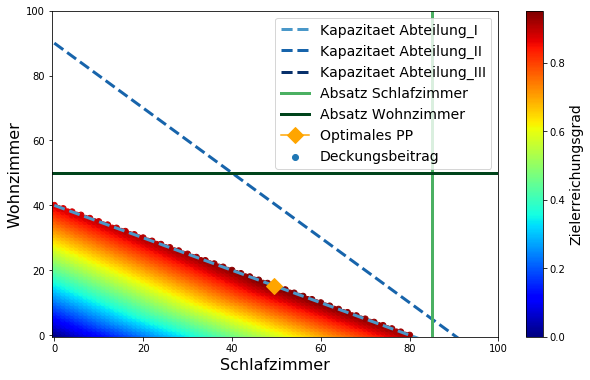

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
s = np.linspace(0, 100)

# Kapazitätsrestriktionen
colors1 = plt.cm.Blues(np.linspace(0.6,1.0,3))
n = 0
for j in Abteilungen:    
    plt.plot(s,(r.loc[j,'r']-s*a.loc['Schlafzimmer',j])/a.loc['Wohnzimmer',j], lw=3,
             c=colors1[n], linestyle='dashed', label='Kapazitaet '+j)
    n += 1
    
# Absatzrestriktionen
colors2 = plt.cm.Greens(np.linspace(0.6,1.0,2))
plt.axvline(x=data.loc['Schlafzimmer','Absatzhoechstmenge'], lw=3,
            c=colors2[0],linestyle='solid', label='Absatz Schlafzimmer')
plt.axhline(y=data.loc['Wohnzimmer','Absatzhoechstmenge'], lw=3,
            c=colors2[1], linestyle='solid', label='Absatz Wohnzimmer')

# Zielfunktion plotten
pairs = [(x, y) for x in np.arange(101)
                for y in np.arange(101)
                if (x * a.loc['Schlafzimmer','Abteilung_I'] + y * a.loc['Wohnzimmer','Abteilung_I']) <= r.loc['Abteilung_I','r']
                and (x * a.loc['Schlafzimmer','Abteilung_II'] + y * a.loc['Wohnzimmer','Abteilung_II']) <= r.loc['Abteilung_II','r']
                and (x * a.loc['Schlafzimmer','Abteilung_III'] + y * a.loc['Wohnzimmer','Abteilung_III']) <= r.loc['Abteilung_III','r']         
                and x <= data.loc['Schlafzimmer','Absatzhoechstmenge']
                and y <= data.loc['Wohnzimmer','Absatzhoechstmenge']]


xx, xy = np.hsplit(np.array(pairs), 2)

z = np.minimum(((xx * data.loc['Schlafzimmer','DB'] + xy * data.loc['Wohnzimmer','DB']) / value(probDB.objective)),
        ((xx * data.loc['Schlafzimmer','Preis'] + xy * data.loc['Wohnzimmer','Preis']) / value(probU.objective)))

plt.scatter(xx, xy, c=z, cmap='jet', label='Deckungsbeitrag', zorder=2)

# Optimales Produktionsprogramm
plt.plot([xZ['Schlafzimmer'].varValue], [xZ['Wohnzimmer'].varValue], marker='D', markersize=12,
         label='Optimales PP', color="orange")


# Diagramm erstellen
cb = plt.colorbar()
cb.set_label('Zielerreichungsgrad', fontsize=14)
plt.xlabel('Schlafzimmer', fontsize=16)
plt.ylabel('Wohnzimmer', fontsize=16)
plt.xlim(-0.5, 100)
plt.ylim(-0.5, 100)
plt.legend(fontsize=14)
plt.show()

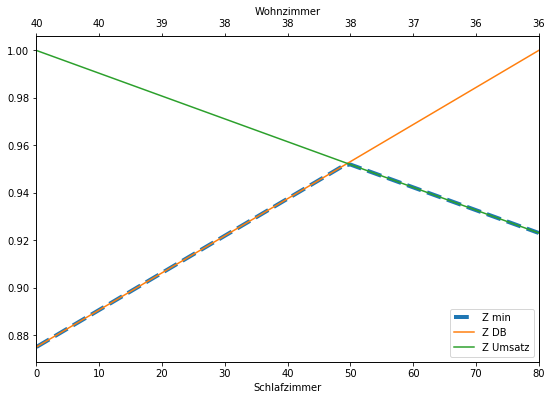

In [16]:
dfZ = pd.DataFrame()
dfZ['x1'] = list(range(0, 81))
dfZ['x2'] = (r.loc['Abteilung_I','r']-dfZ['x1']*a.loc['Schlafzimmer','Abteilung_I'])/a.loc['Wohnzimmer','Abteilung_I']

dfZ['DF'] = dfZ['x1'] * data.loc['Schlafzimmer','DB'] + dfZ['x2'] * data.loc['Wohnzimmer','DB']
dfZ['U'] = dfZ['x1'] * data.loc['Schlafzimmer','Preis'] + dfZ['x2'] * data.loc['Wohnzimmer','Preis']

dfZ['ZDB'] = dfZ['DF'] / value(probDB.objective)
dfZ['ZU'] = dfZ['U'] / value(probU.objective)
dfZ['Z'] = np.minimum(dfZ['ZDB'],dfZ['ZU'])

fig, ax = plt.subplots(figsize=(9, 6))

ax1 = plt.gca()

dfZ.plot(kind='line',x='x1',y='Z', linewidth=4,
         linestyle='dashed', label='Z min', ax=ax1)
dfZ.plot(kind='line',x='x1',y='ZDB',label='Z DB',ax=ax1)
dfZ.plot(kind='line',x='x1',y='ZU',label='Z Umsatz',ax=ax1)


ax2 = ax1.twiny()
ax2ticks = ["%.0f" % i for i in dfZ['x2']]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticklabels(ax2ticks)

ax1.set_xlabel('Schlafzimmer')
ax2.set_xlabel('Wohnzimmer')

plt.show()